In [85]:
from sshtunnel import SSHTunnelForwarder
import pymysql
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import numpy as np
import matplotlib.patches as mpatches

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import r2_score #R square
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgbm
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import pca as pca

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

### Connect to server

In [86]:
server = SSHTunnelForwarder(
ssh_address=('ipa-008.ucd.ie', 22),
ssh_username="student",
ssh_password="6!#5/6_Dublinbus",
remote_bind_address=("localhost", 3306))
### Connect to server### Read Dublin Bus route data

### Read Dublin Bus route data

In [87]:
def getRouteDataFromDB(routeID):
    
    server.start()
    con = pymysql.connect(user='root',
                          passwd='Dublinbus_6!#5/6',
                          db='dublinbus',
                          host='localhost',
                          port=server.local_bind_port)

    df = pd.read_sql_query('SELECT * FROM dublinbus.route_%s;' % routeID, con)
    con.close()
    return df


### Get extra features
 - **date:** date of the DAYOFSERVICE
 - **month:** month of the DAYOFSERVICE
 - **weekday:** weekday of the DAYOFSERVICE
 - **dep_hour:** hour of ACTUALTIME_DEP
 - **arr_hour:** hour of ACTUALTIME_ARR
 - **isPeaktime:** 1 or 0
     - value 1: ACTUALTIME_DEP between 6:30 - 9:30, 15:30 - 18:30
     - value 0: otherwise
 

In [88]:
def addExtraFeatures(df):
    
#   add extra features: 'date', 'month', 'weekday', 'dep_hour', 'arr_hour'
    df.DAYOFSERVICE = pd.to_datetime(df.DAYOFSERVICE) 
    df['date'] = df['DAYOFSERVICE'].dt.day
    df['month'] = df['DAYOFSERVICE'].dt.month
    df['weekday'] = df['DAYOFSERVICE'].dt.weekday
    df['dep_hour'] = (df['ACTUALTIME_DEP'] // 3600) - 1
    df['arr_hour'] = (df['ACTUALTIME_ARR'] // 3600) - 1
    
#   drop the rows which arr_hour < 25
    df = df.loc[df.arr_hour <= 24]
    
    
    # Sort and reindex the df so that each trip is in order
    df = df.sort_values(['DIRECTION', 'DAYOFSERVICE','TRIPID', 'PROGRNUMBER'], ascending=[True, True, True, True])
    df = df.reset_index(drop=True)


    df.loc[(df.PROGRNUMBER > df.PROGRNUMBER.shift(1)) &
                  (df.TRIPID == df.TRIPID.shift(1)) & 
                  (df.DIRECTION == df.DIRECTION.shift(1)) &
                  (df.DAYOFSERVICE == df.DAYOFSERVICE.shift(1))
                  , 'journey_time'] = (df.ACTUALTIME_ARR - df.ACTUALTIME_ARR.shift(1))

    # Calc dwell time
    # df_rev1_1['dwell_time'] = df_rev1_1.ACTUALTIME_DEP - df_rev1_1.ACTUALTIME_ARR

    # Get the previous stop's id
    df.loc[(df.PROGRNUMBER > df.PROGRNUMBER.shift(1)) &
                  (df.TRIPID == df.TRIPID.shift(1)) & 
                  (df.DIRECTION == df.DIRECTION.shift(1)) &
                  (df.DAYOFSERVICE == df.DAYOFSERVICE.shift(1))
                  , 'prev_stop_id'] = df.STOPPOINTID.shift(1)

    # Create a segment id by concatenating prev stop id and currnet stop id
    df["segment_id"] = df['prev_stop_id'].map(str) + "-" + df['STOPPOINTID'].map(str)

    # If the progrnumber is 1, that is the first stop, ie there is no previous stop
    # set the journey time, seg id and prev stop to NaN
    df.loc[df['PROGRNUMBER'] == 1, "journey_time"] = np.nan
    df.loc[df['PROGRNUMBER'] == 1, "prev_stop_id"] = np.nan
    df.loc[df['PROGRNUMBER'] == 1, "segment_id"] = np.nan
    
    
    #  add isPeaktime feature
    #  value 1: 6:30 - 9:30, 15:30 - 18:30 
    #  value: otherwise
    df['isPeaktime'] = 0
    df['isPeaktime'] = np.where(((df.ACTUALTIME_DEP >= 23400) & (df.ACTUALTIME_DEP <= 34200)) |
                                   ((df.ACTUALTIME_DEP >= 55800) & (df.ACTUALTIME_DEP <= 66600))
                                   , 1, df['isPeaktime'])
    return df

### Sampling
- return the original dataframe if range of dataframe less than 50 after dropping "segment_id".value_counts() < 50 index. 
- Otherwise, sampling the dataframe by groupby 'segment_id' & 'dep_hour'.
    

In [89]:
def sampling(df):
    
    #   Drop segment_id which value_counts() < 50
    segs_to_drop = list((df["segment_id"].value_counts()[df["segment_id"].value_counts() < 50]).index)
    temp_df = df.query(f'segment_id not in {segs_to_drop}')
    
    
    #     After dropping segment_id, 
    #     If the range of dataframe still greater than 50, 
    #     sampling the dataframe by groupby 'segment_id' and 'dep_hour'
    #     each segment_id sample at most 20 for each hours
    print(temp_df.shape)
#     if (temp_df.shape[0] > 50):
    df = temp_df.groupby(['segment_id', 'arr_hour'], group_keys=False).apply(lambda df: df.sample(20) 
            if df.shape[0] >= 20 else df)
    
    
    #     After dropping segment_id, if dataframe range less than 10, 
    #     then return whole original dataframe
    return df

### Outliner
- replace the outliner journey data (data over 99th percentile) to mean value

In [90]:
def dealWithOutlier(df):
    
    #     get mean value of journey_time
#     journeyTimeMean = df["journey_time"].mean()
    
#     print('99th percentile ', df['journey_time'].quantile(0.995))
    quantile_99 = df['journey_time'].quantile(0.995)
    df = df.loc[df.journey_time < quantile_99]
    #     replace outliner journey_time value to mean value
#     df['journey_time'].replace(df.journey_time > quantile_99 , journeyTimeMean,inplace=True)
    return df

### Drop Columns


In [91]:
def dropColumns(df):
    df = df.loc[ df['journey_time'] >= 0 ]
   
    useless_features = [
      'LINEID',
      'DAYOFSERVICE', 
      'TRIPID', 
      'Unnamed: 0', 
      'datetime', 
      'PROGRNUMBER', 
      'STOPPOINTID', 
      'DIRECTION', 
      'prev_stop_id'
    ]
    
    low_correlation_features = [
     'dep_hour',
     'ACTUALTIME_DEP',
     'ACTUALTIME_ARR',
     'rain',
     'pressure',
     'humidity',
     'wind_dir',
     'visibility',
     'cloud_height',
     'cloud_cover',
     'month']
    
    df = df.drop(columns=useless_features)
    df = df.drop(columns=low_correlation_features)
    
    return df
    

### Add dummys
- **hour_dummies:** from 'dep_hour' column
- **segment_id_dummies:** from 'segment_id' column

In [92]:
def addDummys(df):
    hour_dummies = pd.get_dummies(df['arr_hour'], prefix='arr_hour', drop_first=True)
    segment_id_dummies = pd.get_dummies(df['segment_id'], prefix='segment_id', drop_first=True)
    df = pd.concat([df, hour_dummies, segment_id_dummies], axis=1)
    df = df.drop(['segment_id', 'arr_hour'], axis = 1)
    return df

### Read historical weather dataframe

In [93]:
# read in the cleaned csv
def readWeatherData():
    df_weather = pd.read_csv("weather-data-cleaned.csv")
    df_weather.datetime = pd.to_datetime(df_weather.datetime) 
    df_weather['DAYOFSERVICE'] = df_weather['datetime'].dt.date
    df_weather['arr_hour'] = df_weather['datetime'].dt.hour + 1
    df_weather.DAYOFSERVICE = pd.to_datetime(df_weather.DAYOFSERVICE) 
    return df_weather

In [94]:
def mergeDF(df1, df2, onColumns):
    return pd.merge(df1, df2, how='left', on=onColumns)

In [143]:
# Spot Check Algorithms
models = []
# models.append(('LR', LinearRegression()))
# models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
# models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 20))) 
# models.append(('SVM', SVR())) # kernel = linear
models.append(('XGB', xgb.XGBRegressor(random_state=30)))
models.append(('LGBM', lgbm.LGBMRegressor(boosting_type='rf', 
                                          bagging_freq=1,
                                          bagging_fraction=0.8, 
                                          n_estimators=300)))


In [112]:
def trainNTest(routeID, df):
    
    y = pd.DataFrame(df["journey_time"])
    X = df.drop(["journey_time"],1)

    # Random sample from full df, keep 70% sample for train and remaining 30% sample for test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)
    print("original range is: ",df.shape[0])

    # need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    d = {'routeID': [routeID], 
        'range': df.shape[0]}
    
    for name, model in models:
        start_time = time.time()
        mod = model.fit(X_train, y_train)
        df_test = mod.predict(X_test) 
        mse = mean_squared_error(y_test, df_test) 
        r2 = r2_score(y_test, df_test)
        
        d[name +'_RMSE'] = [np.sqrt(mse)]
        d[name+'_R2'] = [r2]
    
    df = pd.DataFrame(data=d)
    
    return df  

In [178]:
# lines = ['1', '102' ,'104', '11','111' ,'114','116','118','120','122','123','13','130','14','140','142','145'
#          ,'14C','15','150','151','15A','15B','15D','16','161','16C','16D','17','17A','18','184','185','220'
#          ,'236','238','239','25','25A','25B','25D','25X','26','27','270','27A','27B','27X','29A','31','31A',
#          '31B','31D','32','32X','33','33A','33B','33D','33E','33X','37','38','38A','38B','38D','39','39A','39X'
#          ,'4','40','40B','40D','40E','41','41A','41B','41C','41D','41X','42','42D','43','44','44B','45A','46A'
#          ,'46E','47','49','51D','51X','53','54A','56A','59','61','63','65','65B','66','66A','66B','66X','67',
#          '67X','68','68A','68X','69','69X','7','70','70D','75','76','76A','77A','77X','79','79A','7A','7B',
#          '7D','83','83A','84','84A','84X','9']

lines = ['9']



toSolvedRoute = ['16C']
# 37 : not exist
# 33E, 41D : segment value count all less than 20

### Data cleaning / training / Testing  for routes

In [179]:
lines_result_df_2 = pd.DataFrame()
for i in lines:
    print('route', i)
    start_time = time.time()
    df_route = getRouteDataFromDB(i)
    df = df_route.copy()
    df = addExtraFeatures(df_route)
    df_weather = readWeatherData()
    df = mergeDF(df, df_weather, ['DAYOFSERVICE', 'arr_hour'])
    df = dealWithOutlier(df)
    df = sampling(df)
    df = addDummys(df)
    df = dropColumns(df)
    result_df = trainNTest(i, df)
    result_df['running_time'] = time.time() - start_time
    lines_result_df_2 = lines_result_df_2.append(result_df, ignore_index=True)


route 9
(2712903, 29)
original range is:  47563


In [180]:
lines_result_df_2

,routeID,range,RF_RMSE,RF_R2,XGB_RMSE,XGB_R2,LGBM_RMSE,LGBM_R2,running_time
0,9,47563,31.061809,0.642162,30.222441,0.66124,35.156117,0.54161,231.16235


In [181]:
# route 1 -114
# lines_result_df_1 = lines_result_df_1.append(result_df, ignore_index=True)
lines_result_df_1 = lines_result_df_1.append(lines_result_df_2, ignore_index=True)
lines_result_df_1

,routeID,range,RF_RMSE,RF_R2,XGB_RMSE,XGB_R2,LGBM_RMSE,LGBM_R2,running_time
0,1,29948,34.428079,0.610680,33.030893,0.641638,32.592809,0.651081,91.836509
1,102,40000,26.767572,0.809757,25.884343,0.822105,25.391237,0.828818,100.251457
2,104,19876,30.530529,0.711670,29.874289,0.723932,28.953156,0.740694,26.979863
3,11,44782,54.555374,0.544468,51.800231,0.589316,53.644521,0.559552,132.230691
4,111,30375,33.564758,0.538002,32.873536,0.556835,32.526348,0.566146,38.907356
...,...,...,...,...,...,...,...,...,...
121,83A,39994,29.118278,0.711099,27.729971,0.737991,31.569659,0.660408,83.908238
122,84,65755,34.568375,0.645438,34.553094,0.645751,38.685301,0.555955,166.813325
123,84A,15354,41.806156,0.601364,40.070288,0.633781,43.829752,0.561839,23.978037
124,84X,8664,53.509264,0.761897,51.776326,0.777070,64.538742,0.653624,18.573054


In [182]:
lines_result_df_1.to_csv('3_models.csv')

### Testing specific route code

In [141]:
df_route_33E = getRouteDataFromDB('118')
# df_route_33E = pd.read_csv("route_1.csv")
df_route_33E.head()
df_route_33E = addExtraFeatures(df_route_33E)
df_weather = readWeatherData()
df_route_33E = mergeDF(df_route_33E, df_weather, ['DAYOFSERVICE', 'arr_hour'])
df_route_33E = dealWithOutlier(df_route_33E)
df_route_33E = sampling(df_route_33E)
df_route_33E = addDummys(df_route_33E)
df_route_33E = dropColumns(df_route_33E)
result_df = trainNTest('118', df_route_33E)

(13507, 29)
original range is:  1300


In [142]:
result_df

,routeID,range,RF_RMSE,RF_R2,XGB_RMSE,XGB_R2,LGBM_RMSE,LGBM_R2
0,118,1300,61.030137,0.574091,64.654636,0.522,76.37283,0.33303


### Evaluate

In [183]:
df_RF = pd.read_csv("RF_dep_dep.csv")
df_RF

,Unnamed: 0,routeID,MAE,MSE,RMSE,R2,range,running_time
0,0,1,22.282420,22.282420,33.616589,0.622151,29948,6.889797
1,1,102,16.640386,16.640386,27.787550,0.817541,39956,17.751336
2,2,104,18.825854,18.825854,30.059503,0.703294,19875,4.165195
3,3,11,25.095960,25.095960,50.219624,0.659051,44791,24.074608
4,4,111,18.318390,18.318390,33.911704,0.532718,30380,7.639578
...,...,...,...,...,...,...,...,...
123,123,83A,18.528934,18.528934,28.344205,0.732594,39993,22.621848
124,124,84,17.075207,17.075207,32.938335,0.659331,65857,75.951404
125,125,84A,23.284599,23.284599,40.467945,0.615652,15351,5.570846
126,126,84X,31.141348,31.141348,56.816516,0.754929,8666,2.458309


In [9]:
df_RF = df_RF.drop(columns=['Unnamed: 0'])
df_RF.dtypes

routeID          object
MAE             float64
MSE             float64
RMSE            float64
R2              float64
range             int64
running_time    float64
dtype: object

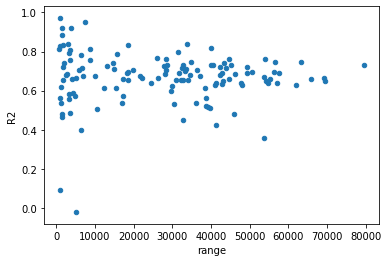

In [5]:

df_RF.plot(kind='scatter', x='range', y='R2')    

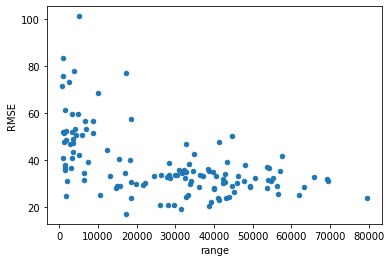

In [6]:
df_RF.plot(kind='scatter', x='range', y='RMSE')  

In [10]:
continuous_columns = df_RF.select_dtypes(['int64', 'float64'])
continuous_describe = continuous_columns.describe().T

continuous_describe

,count,mean,std,min,25%,50%,75%,max
MAE,128.0,22.236838,6.386197,11.558445,18.270264,20.761959,25.137085,46.151450
MSE,128.0,22.236838,6.386197,11.558445,18.270264,20.761959,25.137085,46.151450
RMSE,128.0,38.416174,14.374028,17.218978,29.393282,33.925107,43.810439,101.364079
R2,128.0,0.667214,0.133741,-0.020642,0.628872,0.680265,0.732640,0.970231
range,128.0,27230.539062,19910.720515,811.000000,6462.750000,29125.000000,42335.250000,79514.000000
running_time,128.0,15.476433,19.360113,0.094812,1.442239,8.851176,22.819499,110.282810


### evaluation RF vs XGB vs	LGBM

In [185]:
models_df = pd.read_csv("RF_XGB_LGBM.csv")
models_df

,Unnamed: 0,routeID,range,RF_RMSE,RF_R2,XGB_RMSE,XGB_R2,LGBM_RMSE,LGBM_R2,running_time
0,0,1,29948,34.428079,0.610680,33.030893,0.641638,32.592809,0.651081,91.836509
1,1,102,40000,26.767572,0.809757,25.884343,0.822105,25.391237,0.828818,100.251457
2,2,104,19876,30.530529,0.711670,29.874289,0.723932,28.953156,0.740694,26.979863
3,3,11,44782,54.555374,0.544468,51.800231,0.589316,53.644521,0.559552,132.230691
4,4,111,30375,33.564758,0.538002,32.873536,0.556835,32.526348,0.566146,38.907356
...,...,...,...,...,...,...,...,...,...,...
121,121,83A,39994,29.118278,0.711099,27.729971,0.737991,31.569659,0.660408,83.908238
122,122,84,65755,34.568375,0.645438,34.553094,0.645751,38.685301,0.555955,166.813325
123,123,84A,15354,41.806156,0.601364,40.070288,0.633781,43.829752,0.561839,23.978037
124,124,84X,8664,53.509264,0.761897,51.776326,0.777070,64.538742,0.653624,18.573054


In [186]:
models_df = models_df.drop(columns=['Unnamed: 0'])
models_df.dtypes

routeID          object
range             int64
RF_RMSE         float64
RF_R2           float64
XGB_RMSE        float64
XGB_R2          float64
LGBM_RMSE       float64
LGBM_R2         float64
running_time    float64
dtype: object

In [187]:
continuous_columns = models_df.select_dtypes(['int64', 'float64'])
continuous_describe = continuous_columns.describe().T

continuous_describe

,count,mean,std,min,25%,50%,75%,max
range,126.0,27635.357143,19791.680537,803.000000,6763.000000,29758.000000,42392.750000,79606.000000
RF_RMSE,126.0,38.477790,13.258702,17.728947,29.879338,34.438627,43.798214,87.453539
RF_R2,126.0,0.660920,0.119123,0.181326,0.621171,0.670828,0.711475,0.967242
XGB_RMSE,126.0,37.947756,14.126188,17.222434,29.118445,33.142800,43.251372,91.098399
XGB_R2,126.0,0.676586,0.112680,0.109818,0.611898,0.689069,0.729673,0.961612
LGBM_RMSE,126.0,48.481028,36.975033,18.514328,33.541012,37.341305,49.880062,316.113515
LGBM_R2,126.0,0.548980,0.151664,-0.003124,0.500654,0.565983,0.647705,0.943748
running_time,126.0,90.506553,91.952274,1.368761,14.973536,75.958394,133.418846,425.619397


In [189]:
r2_columns = ['RF_R2', 'XGB_R2', 'LGBM_R2']
RMSE_columns = ['RF_RMSE', 'XGB_RMSE', 'LGBM_RMSE']
colors = ['red','green','blue']

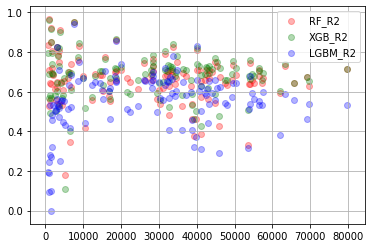

In [200]:
fig, ax = plt.subplots()
for i in range(len(r2_columns)):
    ax.scatter(models_df['range'], 
                models_df[r2_columns[i]],
                label=r2_columns[i],
                alpha=0.3,
                color=colors[i])

ax.legend()
ax.grid(True)

plt.show()

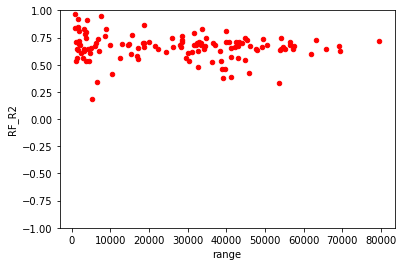

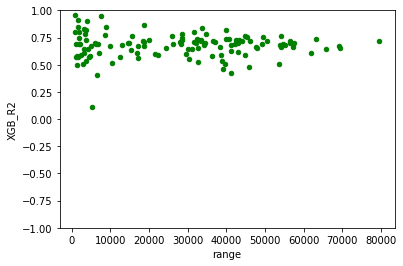

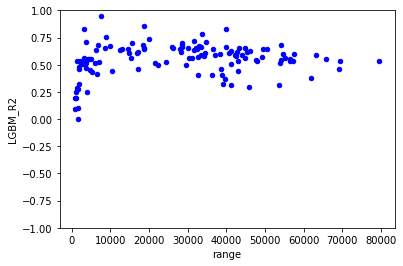

In [208]:
for i in range(len(r2_columns)):
    ax1 = models_df.plot(kind='scatter', x='range', y=r2_columns[i], color=colors[i])
    ax1.set_ylim(-1, 1)

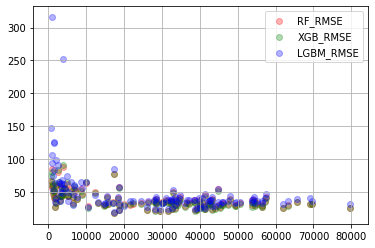

In [202]:
fig, ax = plt.subplots()
for i in range(len(RMSE_columns)):
    ax.scatter(models_df['range'], 
                models_df[RMSE_columns[i]],
                label=RMSE_columns[i],
                alpha=0.3,
                color=colors[i])

ax.legend()
ax.grid(True)

plt.show()

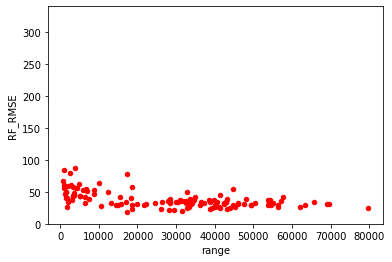

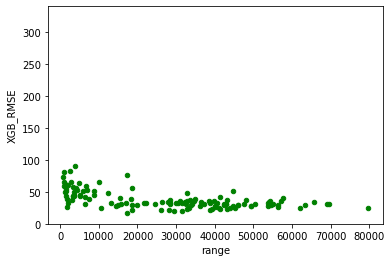

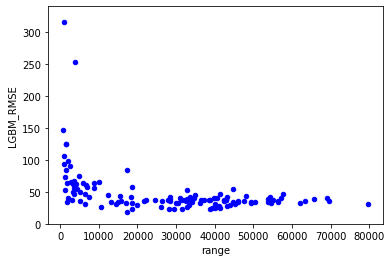

In [212]:
for i in range(len(RMSE_columns)):
    ax1 = models_df.plot(kind='scatter', x='range', y=RMSE_columns[i], color=colors[i])
    ax1.set_ylim(0, 340)